## Electricity price prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
#from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback

Using TensorFlow backend.


In [5]:
# df_price = pd.read_csv('nyiso_price_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
# df_load = pd.read_csv('nyiso_load_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data = pd.read_csv('full_diff_data.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data.set_index('time_stamp', inplace = True)

In [7]:
df_data.loc[:,'price_diff_norm'] = preprocessing.scale(df_data.loc[:, 'price_diff'])
df_data.loc[:,'load_diff_norm'] = preprocessing.scale(df_data.loc[:, 'load_diff'])
df_data.loc[:,'temp_diff_norm'] = preprocessing.scale(df_data.loc[:, 'temp_diff'])

In [8]:
df_data.head()

,time_stamp_local,price,price_24hr_ago,price_diff,load,load_24hr_ago,load_diff,temp,temp_24hr_ago,temp_diff,price_diff_norm,load_diff_norm,temp_diff_norm
time_stamp,,,,,,,,,,,,,
2017-01-01 05:00:00,2017-01-01 00:00:00,32.28,35.47,-3.19,5011.2,5128.0,-116.8,46.0,35.0,11.0,-0.107472,-0.204725,1.449054
2017-01-01 06:00:00,2017-01-01 01:00:00,30.77,34.08,-3.31,4837.3,4896.2,-58.9,45.0,35.0,10.0,-0.111219,-0.105154,1.318114
2017-01-01 07:00:00,2017-01-01 02:00:00,31.17,27.90,3.27,4652.6,4733.9,-81.3,46.0,35.0,11.0,0.094225,-0.143675,1.449054
2017-01-01 08:00:00,2017-01-01 03:00:00,32.00,28.09,3.91,4500.7,4640.7,-140.0,46.0,35.0,11.0,0.114207,-0.244622,1.449054
2017-01-01 09:00:00,2017-01-01 04:00:00,27.89,27.20,0.69,4423.5,4610.1,-186.6,47.0,34.5,12.5,0.013671,-0.324760,1.645465


In [9]:
def feature_target_split(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
        except:
            break
        X.append(x_i)
        Y.append(y_i)
    return X, Y

In [10]:
def shuffle_Xy(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [11]:
def train_test_ts_split(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [12]:
TRAIN_SIZE = 7 * 24
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

In [13]:
# len(df_price.lbmp_price_scaled.values), len(df_load.load_scaled.values)

In [67]:
# df_price.set_index('time_stamp', inplace = True)
# df_load.set_index('time_stamp', inplace = True)

# df_load_new = df_load.reindex(df_price.index)

# df_load_new.load.fillna(0., inplace = True)
# df_load_new.load_scaled.fillna(0., inplace = True)

# sum(df_load_new.load.isnull())

# set(df_price.index.values) - set(df_load_new.index.values)

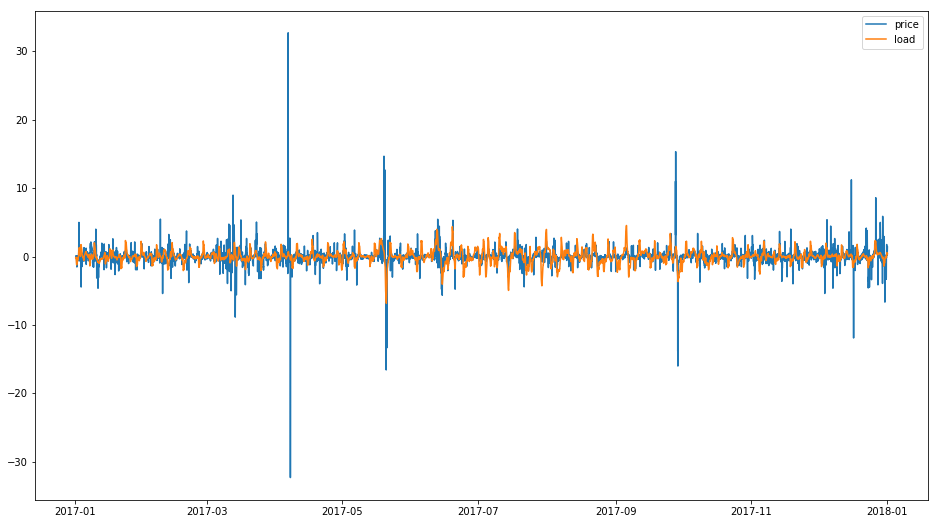

In [19]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_data.index, df_data.price_diff_norm, label = 'price')
ax.plot(df_data.index, df_data.load_diff_norm, label = 'load')
ax.legend()

In [14]:
X, Y = feature_target_split(df_data.price_diff_norm.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage=0.9)

Xp, Yp = feature_target_split(df_data.load_diff_norm.values, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = train_test_ts_split(Xp, Yp, percentage=0.9)

In [17]:
model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          nb_epoch=10, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 6957 samples, validate on 774 samples
Epoch 1/10
6957/6957 [==============================] - 1s 105us/step - loss: 1.1328 - val_loss: 0.4684
Epoch 2/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.8478 - val_loss: 0.4224
Epoch 3/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.7199 - val_loss: 0.3955
Epoch 4/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.6211 - val_loss: 0.3701
Epoch 5/10
6957/6957 [==============================] - 1s 86us/step - loss: 0.5626 - val_loss: 0.3647
Epoch 6/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.5166 - val_loss: 0.3716
Epoch 7/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.5202 - val_loss: 0.3779
Epoch 8/10
6957/6957 [==============================] - 1s 84us/step - loss: 0.4828 - val_loss: 0.3675
Epoch 9/10
6957/6957 [==============================] - 1s 90us/step - loss: 0.4666 - val_loss: 0.4002
Epoch 10/10
860/860 [====

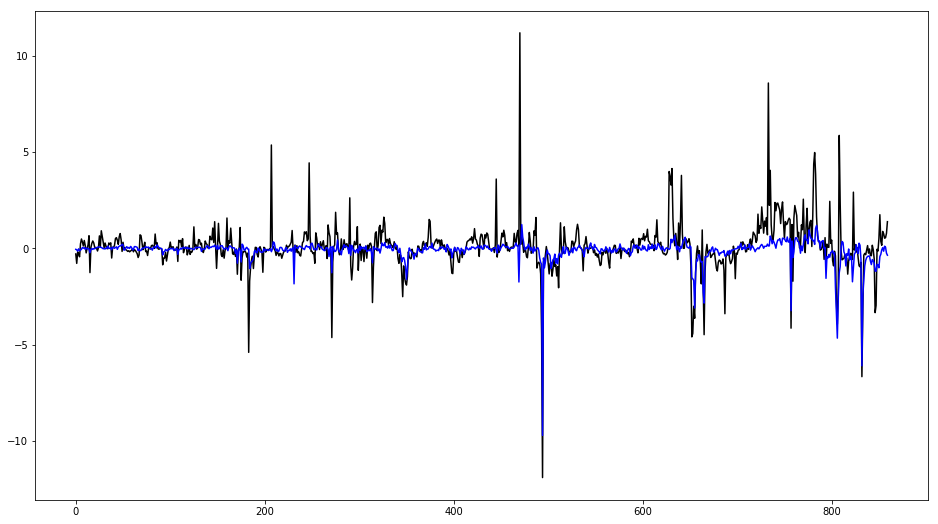

In [16]:
predicted = model.predict(X_test)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_test[:1000], color='black')
    plt.plot(predicted[:1000], color='blue')
    plt.show()
except Exception as e:
    print(str(e))

In [75]:
score

0.015468353180582898

In [76]:
model2 = Sequential()
model2.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(250))
model2.add(Activation('relu'))
model2.add(Dense(1))
model2.add(Activation('linear'))
model2.compile(optimizer='adam', 
              loss='mse')

model2.fit(X_trainp, 
          Y_trainp, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score2 = model2.evaluate(X_testp, Y_testp, batch_size=128)

/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 63194 samples, validate on 7022 samples
Epoch 1/5
63194/63194 [==============================] - 7s 109us/step - loss: 0.3419 - val_loss: 0.3086
Epoch 2/5
63194/63194 [==============================] - 7s 109us/step - loss: 0.2744 - val_loss: 0.2699
Epoch 3/5
63194/63194 [==============================] - 7s 118us/step - loss: 0.2640 - val_loss: 0.2868
Epoch 4/5
63194/63194 [==============================] - 7s 114us/step - loss: 0.2544 - val_loss: 0.3155
Epoch 5/5
7802/7802 [==============================] - 0s 50us/step


In [77]:
score2

2.6629627948888057

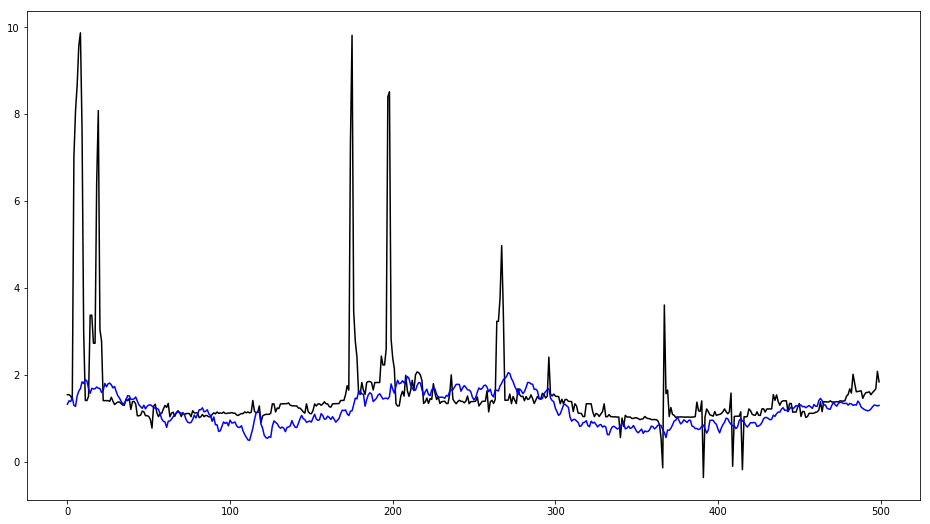

In [79]:
predicted2 = model2.predict(X_testp)
try:
    fig = plt.figure(figsize=(16, 9))
    plt.plot(Y_testp[:500], color='black')
    plt.plot(predicted2[:500], color='blue')
    plt.show()
except Exception as e:
    print(str(e))